## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS



In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from textblob import TextBlob

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json', 'r')
# returns JSON object as  
# a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [ ]:
# drop unique ID columns because they will not be useful for training any models
df.drop(['_index', '_id'], axis=1, inplace=True)

In [ ]:
#print the column names
print(df.columns)

Index(['_type', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assign new column names
df.columns = df.columns.str.replace('^_', '')
df.columns = df.columns.str.replace('^source.', '')
df.rename({'complaint_what_happened' : 'complaint'}, axis=1, inplace=True)
print(df.columns)

Index(['type', 'score', 'tags', 'zip_code', 'complaint_id', 'issue',
       'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaint',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint'].replace(to_replace={'' : np.nan}, inplace=True)
df['complaint'].isnull().sum()

57241

In [ ]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'], how='any')
df['complaint'].isnull().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.

#Make complaint strings all lowercase
df['complaint'] = df['complaint'].str.lower()

#Remove all punctuation
df['complaint'] =  [re.sub(r'[^\w\s]',  '', str(x)) for x in df['complaint']]

#Remove any word with numbers in it
df['complaint'] =  [re.sub(r'\S*\d\S*',  '', str(x)) for x in df['complaint']]

#remove square brackets and anything in them
df['complaint'] =  [re.sub(r'\[.*?\]',  '', str(x)) for x in df['complaint']]

In [ ]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint']].copy()
df_clean["complaint_lemmatize"] =  df_clean.apply(lambda x: lemmatize_text(x['complaint']), axis=1)

In [ ]:
df_clean

,complaint,complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...


In [ ]:
#Write your function to extract the POS tags 
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_adjectives(x['complaint_lemmatize']), axis=1)


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,i call chas -PRON- credit card provider claim ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i -PRON- bank app ch...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




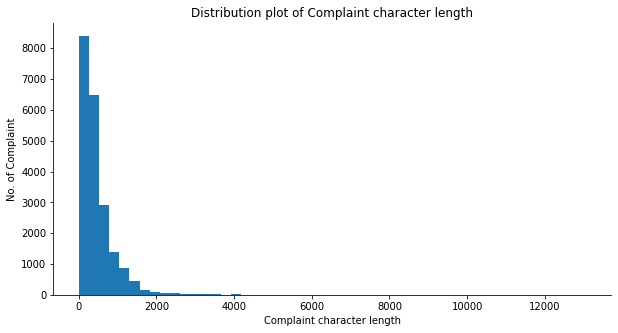

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,5))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution plot of Complaint character length')
plt.ylabel('No. of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

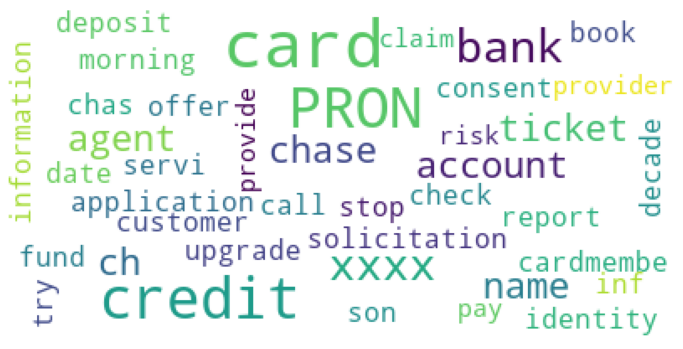

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
plt.figure(figsize=(12,8))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                      background_color='white', stopwords=stopwords,
                      max_words=40, max_font_size=40, random_state=42
                     ).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def extract_top_words_from_text(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = extract_top_words_from_text(df_clean['Complaint_clean'].values.astype('U'), 30)
df_common_words = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
fig = go.Figure([go.Bar(x=df_common_words['unigram'], y=df_common_words['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the Complaint text after processing the text"))
fig.show()

In [ ]:
#Print the top 10 words in the unigram frequency
df_common_words.head(10)

,unigram,count
0,chase,50030
1,account,47175
2,credit,34155
3,xxxx,34026
4,card,29083
5,bank,28399
6,payment,21163
7,time,16031
8,charge,15542
9,day,12975


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def extract_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = extract_top_bigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
df_common_bigrams = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df_common_bigrams['bigram'], y=df_common_bigrams['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after processing the text"))
fig.show()

In [ ]:
#Print the top 10 words in the bigram frequency
df_common_bigrams.head(10)

,bigram,count
0,credit card,12777
1,credit report,3979
2,xxxx xxxx,3451
3,chase bank,3379
4,customer service,3078
5,chase credit,2946
6,bank account,2773
7,account chase,2699
8,chase account,2386
9,account account,2287


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def extract_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
    
common_words = extract_top_trigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
df_common_trigrams = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df_common_trigrams['trigram'], y=df_common_trigrams['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the Complaint text"))
fig.show()

In [ ]:
#Print the top 10 words in the trigram frequency
df_common_trigrams.head(10)

,trigram,count
0,chase credit card,2021
1,credit card account,1024
2,credit card company,991
3,credit card chase,644
4,credit card credit,493
5,inquiry credit report,489
6,charge credit card,458
7,chase customer service,407
8,account credit card,386
9,credit reporting agency,381


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,i call chas -PRON- credit card provider claim ...,i call chas credit card provider claim purcha...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer i -PRON- bank app ch...,pay risk provide consumer i bank app chase ye...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 

tf_idf_vector = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tf_idf_vector.fit_transform(df_clean['Complaint_clean'])



## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5
#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40)
#write your code here

In [ ]:
nmf_model.fit(dtm)
len(tf_idf_vector.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



13

In [ ]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR EACH TOPIC #{index}')
    print([tf_idf_vector.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR EACH TOPIC #0
['application', 'ask', 'card', 'consent', 'credit', 'information', 'report', 'service', 'statement', 'date', 'account', 'bank', 'chase']


THE TOP 15 WORDS FOR EACH TOPIC #1
['consent', 'date', 'service', 'card', 'ask', 'statement', 'bank', 'account', 'information', 'report', 'credit', 'chase', 'application']


THE TOP 15 WORDS FOR EACH TOPIC #2
['application', 'ask', 'bank', 'chase', 'credit', 'report', 'service', 'statement', 'account', 'card', 'information', 'consent', 'date']


THE TOP 15 WORDS FOR EACH TOPIC #3
['application', 'card', 'credit', 'date', 'report', 'consent', 'account', 'chase', 'information', 'ask', 'statement', 'service', 'bank']


THE TOP 15 WORDS FOR EACH TOPIC #4
['account', 'ask', 'bank', 'chase', 'date', 'information', 'statement', 'card', 'application', 'credit', 'report', 'consent', 'service']




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

best_topic_each_complaint = nmf_model.transform(dtm)
best_topic_each_complaint[0].round(2)
best_topic_each_complaint[0].argmax()
best_topic_each_complaint.argmax(axis=1)


array([3, 2, 4, 1, 0])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topic_each_complaint.argmax(axis=1)
#write your code to assign topics to each rows.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.head()

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,3
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,2
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,4
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,1
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,2
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card", 2:"Others",3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,Theft/Dispute Reporting
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,Others
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Mortgage/Loan
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Mortgage/Loan":4}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning -PRON- name -PRON- stop bank cardmembe...,morning name stop bank cardmember service as...,3
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,2
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,4
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket i offer ticket card i inf...,try book ticket i offer ticket card i informa...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son check deposit -PRON- chase account fund ch...,son check deposit chase account fund chase ba...,0


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint","Topic"]]



In [ ]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,3
2,i upgraded my xxxx xxxx card in and was told ...,2
10,chase card was reported on however fraudulent...,4
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint)


#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf_transformer = TfidfTransformer()
X_train_tfidf = tf_idf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
model1 = LogisticRegression(random_state=0).fit(X_train, y_train)



In [174]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
model2 = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)


In [177]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
model3 = RandomForestClassifier(max_depth=10, random_state=0)
model3.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

\**Based on evaluation of these three models matrices the best model can selected**